# 文章正反面二元分類

In [2]:
# 載入資料
import pandas as pd

raw_data = pd.read_csv("data/ptt/PTT_Gossiping_20161105_20161112_post.csv")

/Users/Mark1002/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [34]:
raw_data.shape

(18104, 12)

In [23]:
# 分詞前處理

import jieba
import re

# stopword
with open("data/jieba_dict/stopwords.txt") as stop_words:
    stop_word_list = [stop_word.strip() for stop_word in stop_words]

# 載入支援繁中較好的分詞
jieba.set_dictionary("data/jieba_dict/dict.txt.big")

corpus, y = [], []

push_threshold = 68
boo_threshold = 21

for i in range(len(raw_data)):
    if int(raw_data.iloc[i]['推']) > push_threshold:
        # r"[\u4e00-\u9fa5]+" 正則表示式，表只取出中文
        seg_list = list(jieba.cut("".join(re.findall(r"[\u4e00-\u9fa5]+", raw_data.iloc[i]['POST_CONTENT']))))
        corpus.append(" ".join(seg_list))
        y.append(1)
    elif int(raw_data.iloc[i]['噓']) > boo_threshold:
        seg_list = list(jieba.cut("".join(re.findall(r"[\u4e00-\u9fa5]+", raw_data.iloc[i]['POST_CONTENT']))))
        corpus.append(" ".join(seg_list))
        y.append(0)

Building prefix dict from /Users/Mark1002/Desktop/project/python/nlp-experiment/data/jieba_dict/dict.txt.big ...
Dumping model to file cache /var/folders/dw/m2zgs87j3x19nl8mnfy3fs8c0000gn/T/jieba.ud2b054c4d13e51557150f7d36ba5f4d0.cache
Loading model cost 2.981 seconds.
Prefix dict has been built succesfully.


In [42]:
print("corpus length: {}".format(len(corpus)))
print("neg count: {}".format(len(list(filter(lambda x: x==0,y)))))
print("pos count: {}".format(len(list(filter(lambda x: x==1,y)))))

corpus length: 1044
neg count: 464
pos count: 580


## tf-idf 分詞前處理

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words=stop_word_list)
# 將出現的文字轉換成 tf-idf 特徵權重
X = vectorizer.fit_transform(corpus)
X.shape

(1044, 9591)

## WordToVec 處理

In [74]:
from gensim.models import word2vec

In [84]:
model = word2vec.Word2Vec(list(map(lambda x: x.split(" "), corpus)), min_count=1, window=10, sg=1)

In [124]:
X = []
for doc in corpus:
    doc_vec = sum([model.wv.get_vector(word) for word in doc.split(" ")]) / len(doc.split(" "))
    X.append(doc_vec)
X = np.array(X)

In [140]:
# 切分訓練與測試資料
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [141]:
# train model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [142]:
# 模型準確度評估
from sklearn.metrics import precision_score, recall_score

print('Train Accuracy:', clf.score(X_train, y_train))
print('Test Accuracy:', clf.score(X_test, y_test))

print('Test Precision:', precision_score(y_test, clf.predict(X_test)))
print('Test Recall:', recall_score(y_test, clf.predict(X_test)))

Train Accuracy: 0.9377245508982036
Test Accuracy: 0.6985645933014354
Test Precision: 0.7083333333333334
Test Recall: 0.8292682926829268


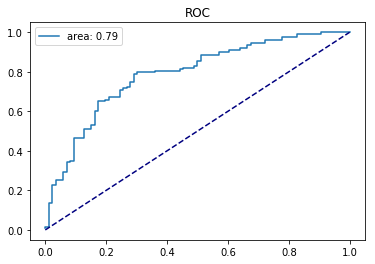

In [143]:
# roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.title('ROC')
plt.plot(fpr, tpr, label="area: %.2f" %auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()
plt.show()

# 參考

1. https://read01.com/zh-tw/0eROKz.html#.W4IhJpMzZsM